Shape: (32561, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
   age         workclass  fnlwgt  education  education_num      marit

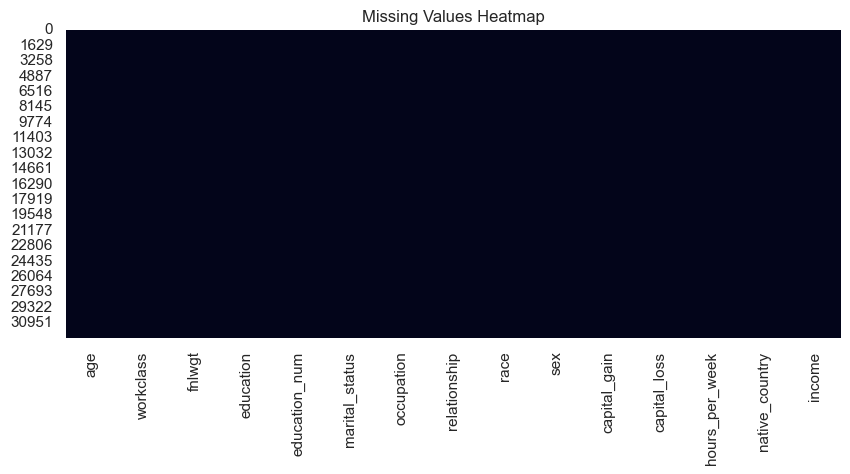


Duplicate rows: 24
Shape after removing duplicates: (32537, 15)


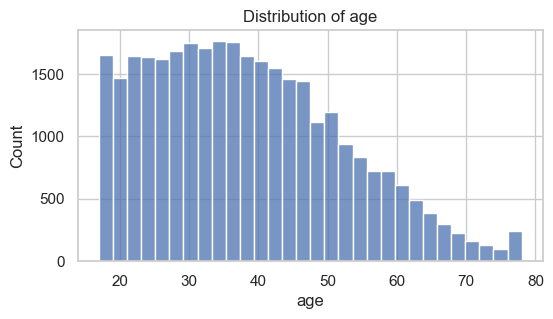

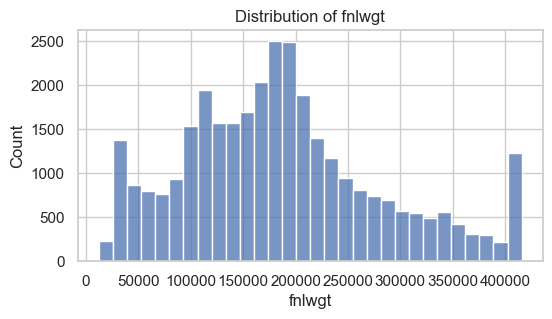

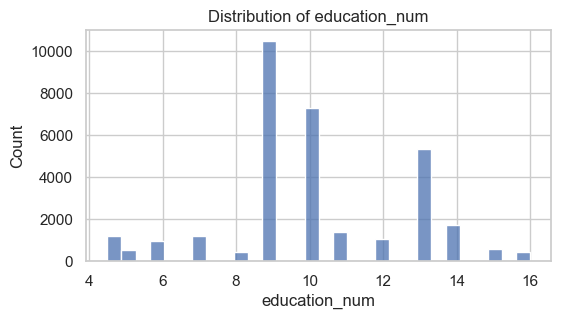

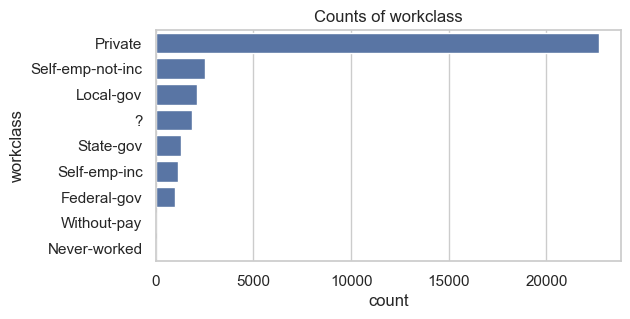

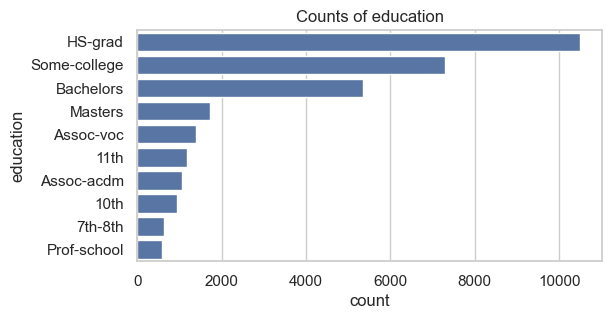

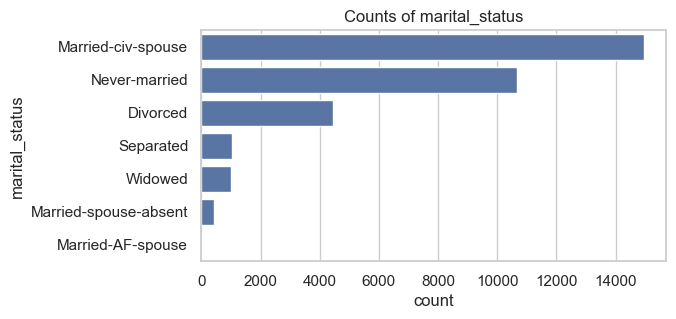

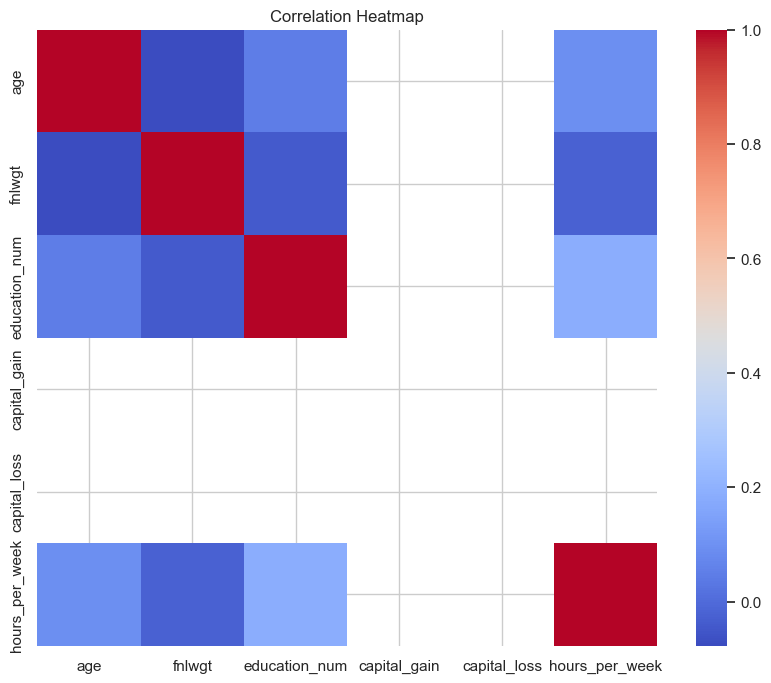


Class distribution before:
income
0    24698
1     7839
Name: count, dtype: int64

Class distribution after:
income
0    24698
1    24698
Name: count, dtype: int64

Top features (Mutual Info):
fnlwgt            0.247682
relationship      0.167455
marital_status    0.156932
age               0.104041
occupation        0.085868
education         0.084614
education_num     0.083151
hours_per_week    0.058956
sex               0.040882
workclass         0.024416
dtype: float64

Final dataset saved as adult_cleaned.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import resample

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

# Load dataset
data = pd.read_csv("adult.data", header=None, na_values=" ?", skipinitialspace=True)
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]
data.columns = columns

print("Shape:", data.shape)
print(data.info())
print(data.head())

# Missing values
print("\nMissing values:")
print(data.isnull().sum())

plt.figure(figsize=(10, 4))
sns.heatmap(data.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Fill missing values
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=["object"]).columns

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

data[num_cols] = num_imputer.fit_transform(data[num_cols])

for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Duplicates
print("\nDuplicate rows:", data.duplicated().sum())
data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)

# Outlier detection + capping
def cap_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

for col in num_cols:
    data[col] = cap_outliers(data[col])

# Univariate analysis
for col in num_cols[:3]:
    plt.figure(figsize=(6, 3))
    sns.histplot(data[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

for col in cat_cols[:3]:
    plt.figure(figsize=(6, 3))
    sns.countplot(y=col, data=data, order=data[col].value_counts().index[:10])
    plt.title(f"Counts of {col}")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data[num_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Encode categorical features
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col].astype(str))

# Feature scaling
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Handle class imbalance
print("\nClass distribution before:")
print(data["income"].value_counts())

dfs = []
max_size = data["income"].value_counts().max()
for cls in data["income"].unique():
    subset = data[data["income"] == cls]
    if len(subset) < max_size:
        subset = resample(subset, replace=True, n_samples=max_size, random_state=42)
    dfs.append(subset)
data = pd.concat(dfs)

print("\nClass distribution after:")
print(data["income"].value_counts())

# Feature selection with Mutual Information
X = data.drop(columns=["income"])
y = data["income"]

mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("\nTop features (Mutual Info):")
print(mi_series.head(10))

# Save cleaned dataset
data.to_csv("adult_cleaned.csv", index=False)
print("\nFinal dataset saved as adult_cleaned.csv")
